In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
import keras

In [2]:
from pyspark.sql import SparkSession

In [3]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [4]:
sc.master

'local[*]'

In [5]:
spark = SparkSession.builder.appName("ImagePreprocessing").getOrCreate()


In [6]:
hdfs_image_folder = "hdfs://localhost:9000/lfw_funneled/*/*.jpg"
image_files_rdd = spark.sparkContext.binaryFiles(hdfs_image_folder)

In [7]:
from PIL import Image
import io

def preprocess_image(file_path, image_bytes):
    image = Image.open(io.BytesIO(image_bytes))
    return file_path, image.tobytes()


In [8]:
preprocessed_images_rdd = image_files_rdd.map(lambda x: preprocess_image(x[0], x[1]))


In [27]:
batch_size = 200

data_set = tf.keras.preprocessing.image_dataset_from_directory(
  'lfw_funneled',
  image_size=(250, 250),
  batch_size=batch_size)

Found 13233 files belonging to 5749 classes.


In [10]:
class_names = data_set.class_names

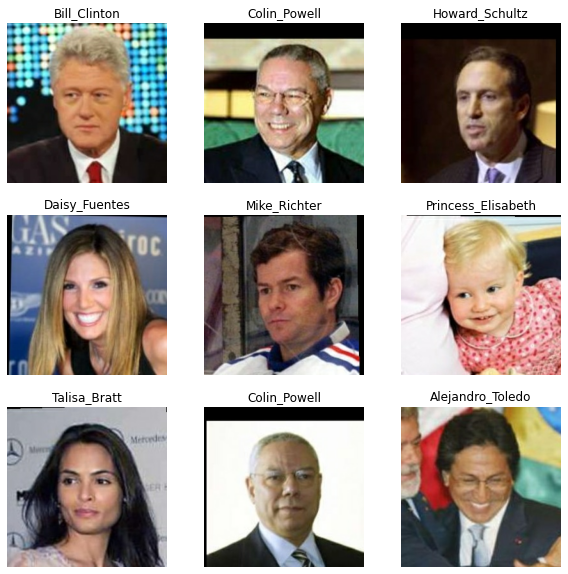

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in data_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = data_set.map(lambda x, y: (normalization_layer(x), y))

In [42]:
class Autoencoder(Model):
    def __init__(self, latent_dim, shape):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.shape = shape
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(16, (3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D((2, 2), padding="same"),
            layers.Conv2D(16, (3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D((2, 2), padding="same"),
            layers.Conv2D(8, (3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D((2, 2), padding="same"),
            layers.Conv2D(8, (3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D((2, 2), padding="same")
        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2D(8, (3, 3), activation="relu", padding="same"),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(8, (3, 3), activation="relu", padding="same"),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(8, (3, 3), activation="relu", padding="same"),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(16, (3, 3), activation="sigmoid", padding="same"),  
            #layers.Reshape(shape)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

sample_instance = next(iter(normalized_ds))[0]

shape = (batch_size, 250, 250, 3)
latent_dim = 10
autoencoder = Autoencoder(latent_dim, shape)

In [43]:
autoencoder.build(input_shape=shape)

In [44]:
autoencoder.summary()

Model: "autoencoder_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_22 (Sequential)  (200, 16, 16, 8)          4512      
                                                                 
 sequential_23 (Sequential)  (200, 128, 128, 16)       2920      
                                                                 
Total params: 7432 (29.03 KB)
Trainable params: 7432 (29.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
autoencoder.compile(optimizer="adam", loss="mse")

In [ ]:
autoencoder.fit(
  normalized_ds,
  validation_data=normalized_ds,
  epochs=3,
  batch_size=50,
)